In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

sys.path.append(os.path.join(os.getcwd(), ".."))
from support.generate_ar_data import *
from support.pd_support import *
from support.calculations_support import *
from support.mecanum_calculations import *
from support.ar_calculations import *
import multiprocessing

In [15]:
_parent_folder = "multi_cam_nov_14"
_folder_name = "sk16_15_quad_fast"
_calib_filename = "calibration_15fps_quad"

_base_pth = os.path.dirname(os.getcwd())
_base_pth = os.path.join(_base_pth, "recording_programs", "test_data")

_pth = os.path.join(_base_pth, _parent_folder, _folder_name)
_calib_pth = os.path.join(_base_pth, _parent_folder, _calib_filename)
_pth

'c:\\Users\\Sujith\\Documents\\Projects\\armbo\\recording_programs\\test_data\\multi_cam_nov_14\\sk16_15_quad_fast'

In [11]:
_recorded_folder_list = os.listdir(os.path.join(_base_pth, _parent_folder))
_txt_pth = os.path.join(_base_pth, _parent_folder,"00_analysis", "folder_list.txt")
with open(_txt_pth, "w") as f:
    for i in _recorded_folder_list:
        f.write(i + "\n")

In [16]:
#calibration path
_webcam_calib_pth = os.path.join(_calib_pth, "webcam_calibration.msgpack")

#open the calibration files
with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]

print("camera matrix", _webcam_cam_mat)
print("distortion", _webcam_dist)


camera matrix [[868.26070009   0.         372.25985418]
 [  0.         874.44598128 238.35209445]
 [  0.           0.           1.        ]]
distortion [[ 7.07394532e-02 -3.42419375e-02 -1.86205766e-03  8.20734788e-04
  -4.82051694e+00]]


In [17]:
def iter_analysis(_pth, _webcam_cam_mat, _webcam_dist):
    #webcam path
    _webcam_video_pth = os.path.join(_pth, "webcam_color.msgpack")

    #timestamp path
    _webcam_timestamp_pth = os.path.join(_pth, "webcam_timestamp.msgpack")
    _w_df = get_ar_pose_data(_webcam_video_pth, _webcam_cam_mat, _webcam_dist, is_color=False, single_file=True, flip_frame=True)
    _w_df = add_time_from_file(_w_df, _webcam_timestamp_pth)
    # get percentage of nan values
    percent_missing = _w_df["x"].isnull().sum() * 100 / len(_w_df["x"])
    total_frames = len(_w_df["x"])
    missing_frames = _w_df["x"].isnull().sum()
    return percent_missing, total_frames, missing_frames

In [18]:
# available cores
print("cores", multiprocessing.cpu_count())
# maximum threads


cores 4


In [19]:
# read foldernames from txt file
with open(_txt_pth, "r") as f:
    _folder_list = f.readlines()
_folder_list = [i.strip() for i in _folder_list]

# create a dataframe to store the data
df = pd.DataFrame(columns = ["folder_name", "total_frames", "missing_frames", "percentage_missing"])

"""
These are the list of data to accquire
"""

# loop through the folders
_per_missing = []
_total_frame_list = []
_missing_frame_list = []
fps_val = []
speed_val = []
quad_val = []

"""
Thread function
"""

def thread_fun(_folder_name):
    _tmp_pth = os.path.join(_base_pth, _parent_folder, _folder_name)
    _p, _t, _m = iter_analysis(_tmp_pth, _webcam_cam_mat, _webcam_dist)
    _per_missing.append(_p)
    _total_frame_list.append(_t)
    _missing_frame_list.append(_m)
    
    # check fps value
    fps_val.append(int(_folder_name.split("_")[1]))
    # check speed of movement
    speed_val.append(_folder_name.split("_")[3])
    # check if quad or skateboard
    if _folder_name.split("_")[2] == "quad":
        quad_val.append("quad")
    else:
        quad_val.append("skateboard")

with multiprocessing.Pool() as pool:
    pool.map(thread_fun, _folder_list)



In [11]:
df["folder_name"] = _folder_list
df["total_frames"] = _total_frame_list
df["missing_frames"] = _missing_frame_list
df["percentage_missing"] = _per_missing
df["fps"] = fps_val
df["speed"] = speed_val
df["object"] = quad_val

In [12]:
# df to csv
df.to_csv(os.path.join(_base_pth, _parent_folder, "00_analysis", "missing_data.csv"), index=False)

In [28]:
# list folder names
# read from csv file
df = pd.read_csv(os.path.join(_base_pth, _parent_folder, "00_analysis", "missing_data.csv"))

In [47]:
# based on fps
fps = 60
_obj = "quad"
print(df[(df["fps"] == fps) & (df["object"] == _obj)]["percentage_missing"].mean())
print(df[(df["fps"] == fps) & (df["object"] == _obj)]["percentage_missing"].std())
print(df[(df["fps"] == fps) & (df["object"] == _obj)]["percentage_missing"].max())

1.8163785989943249
1.5572252233363886
3.882755995432052


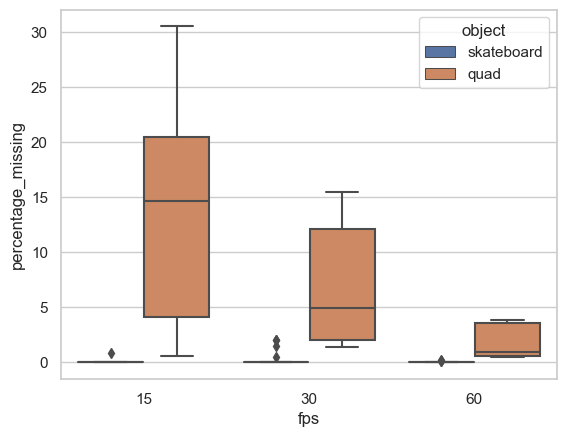

In [31]:
# boxplot
import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="fps", y="percentage_missing", hue="object", data=df)
plt.show()

In [19]:
# based on object
_obj = "skateboard"
_speed = "slow"
print(df[(df["speed"] == _speed) & (df["object"] == _obj)]["percentage_missing"].mean())
print(df[(df["speed"] == _speed) & (df["object"] == _obj)]["percentage_missing"].std())
print(df[(df["speed"] == _speed) & (df["object"] == _obj)]["percentage_missing"].max())

1.0512182907665475
1.675862595044047
3.5175879396984926


In [67]:
# based on movement speed
_obj = "skateboard"
_speed = "fast"
_fps = 60
print(df[(df["speed"] == _speed) & (df["object"] == _obj) & (df["fps"] == _fps)]["percentage_missing"].mean())
print(df[(df["speed"] == _speed) & (df["object"] == _obj) & (df["fps"] == _fps)]["percentage_missing"].std())
print(df[(df["speed"] == _speed) & (df["object"] == _obj) & (df["fps"] == _fps)]["percentage_missing"].max())

0.05517854312850756
0.09501264289496075
0.2141327623126338
